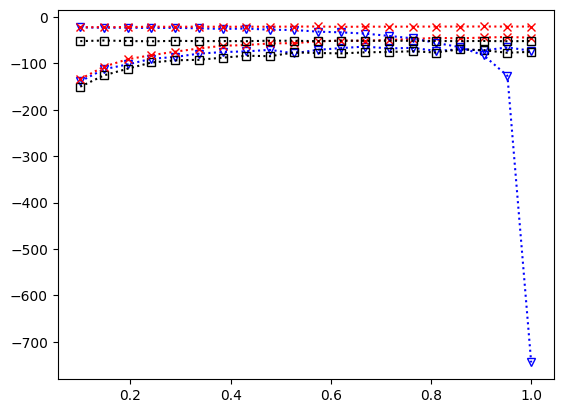

In [43]:
import numpy as np
import matplotlib.pyplot as plt

class CliffWalking:
    def __init__(self) -> None:
        self.height = 4
        self.width = 12
        self.start = (0,0)#row, col
        self.end = (0,11)#row, col
        self.position = list(self.start)

    def state_space(self):
        return (self.height, self.width)
    
    def action_space(self):
        return 4

    def reset(self):
        self.position[:] = self.start
        return self.start

    def step(self, action):
        match action:
            case 0:#down
                self.position[0] = max(self.position[0]-1, 0)
            case 1:#up
                self.position[0] = min(self.position[0]+1, self.height - 1)
            case 2:#left
                self.position[1] = max(self.position[1]-1, 0)
            case 3:#right
                self.position[1] = min(self.position[1]+1, self.width - 1)
        reward = -1
        if self.position[0] == 0 and self.position[1] > 0 and self.position[1] < self.width - 1:
            reward = -100
            self.position[:] = self.start
        terminated = self.position[0] == 0 and self.position[1] == self.width - 1
        #print("pos ",self.position, action)
        return terminated, tuple(self.position), reward

def epsilon_greedy(qs, epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(len(qs))
    else:
        return qs.argmax()

def sarsa(env, num_episodes, alpha, epsilon = 0.1, gamma = 1.0):
    state_shape = env.state_space()
    action_shape = env.action_space()
    q_shape = state_shape + (action_shape,)
    qs = np.zeros(q_shape)
    rewards = 0
    for episode in range(num_episodes):
        state = env.reset()
        action = epsilon_greedy(qs[state], epsilon)
        while True:
            terminated, next_state, reward = env.step(action)
            rewards += reward
            if terminated:
                q_prime = 0
            else:
                next_action = epsilon_greedy(qs[next_state], epsilon)
                q_prime = qs[next_state][next_action]
            qs[state][action] += (reward + q_prime*gamma - qs[state][action])*alpha
            if terminated:
                break
            state = next_state
            action = next_action
    return qs.argmax(-1), rewards

def q_learning(env, num_episodes, alpha, epsilon = 0.1, gamma = 1.0):
    state_shape = env.state_space()
    action_shape = env.action_space()
    q_shape = state_shape + (action_shape,)
    qs = np.zeros(q_shape)
    rewards = 0
    for episode in range(num_episodes):
        state = env.reset()
        while True:
            action = epsilon_greedy(qs[state], epsilon)
            terminated, next_state, reward = env.step(action)
            rewards += reward
            q_prime = 0 if terminated else qs[next_state].max()
            qs[state][action] += (reward + q_prime * gamma - qs[state][action]) * alpha
            if terminated:
                break
            state = next_state
    return qs.argmax(-1), rewards


def expected_sarsa(env, num_episodes, alpha, epsilon = 0.1, gamma = 1.0):
    state_shape = env.state_space()
    action_shape = env.action_space()
    q_shape = state_shape + (action_shape,)
    qs = np.zeros(q_shape)
    rewards = 0
    for episode in range(num_episodes):
        state = env.reset()
        while True:
            action = epsilon_greedy(qs[state], epsilon)
            terminated, next_state, reward = env.step(action)
            rewards += reward
            q_prime = 0 if terminated else qs[next_state].max()*(1-epsilon) + qs[next_state].mean()*epsilon
            qs[state][action] += (reward + q_prime * gamma - qs[state][action]) * alpha
            if terminated:
                break
            state = next_state
    return qs.argmax(-1), rewards

params = [
    [sarsa, 100, 50, [], "bv:"],
    [q_learning, 100, 50, [], "ks:"],
    [expected_sarsa, 100, 50, [], "rx:"],
    [sarsa, 10000, 1, [], "bv:"],
    [q_learning, 10000, 1, [], "ks:"],
    [expected_sarsa, 10000, 1, [], "rx:"],
]

env = CliffWalking()

alpha_count = 20
alphas = [0.9*a/(alpha_count - 1) + 0.1 for a in range(alpha_count)]
for alpha in alphas:
    for param in params:
        algorithm = param[0]
        num_episodes = param[1]
        num_runs = param[2]
        rewards_list = param[3]
        total_rewards = 0
        for n in range(num_runs):
            policy, rewards = algorithm(env, num_episodes, alpha)
            total_rewards += rewards
        rewards_list.append(total_rewards/(num_runs*num_episodes))

plt.ylim((-200,0))
for param in params:
    rewards_list = param[3]
    style = param[4]
    plt.plot(alphas, rewards_list, style, markerfacecolor='none')

#policy, rewards_stat =  sarsa(env, 500, 0.5)
#plt.plot(range(len(rewards_stat)),rewards_stat)
#policy, rewards_stat

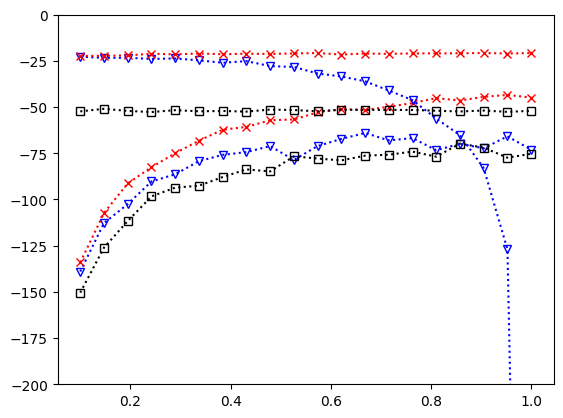

In [44]:
plt.ylim((-200,0))
for param in params:
    rewards_list = param[3]
    style = param[4]
    plt.plot(alphas, rewards_list, style, markerfacecolor='none')


In [26]:
import matplotlib.pyplot as plt
plt.plot?

Signature: plt.plot(*args, scalex=True, scaley=True, data=None, **kwargs)
Docstring:
Plot y versus x as lines and/or markers.

Call signatures::

    plot([x], y, [fmt], *, data=None, **kwargs)
    plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)

The coordinates of the points or line nodes are given by *x*, *y*.

The optional parameter *fmt* is a convenient way for defining basic
formatting like color, marker and linestyle. It's a shortcut string
notation described in the *Notes* section below.

>>> plot(x, y)        # plot x and y using default line style and color
>>> plot(x, y, 'bo')  # plot x and y using blue circle markers
>>> plot(y)           # plot y using x as index array 0..N-1
>>> plot(y, 'r+')     # ditto, but with red plusses

You can use `.Line2D` properties as keyword arguments for more
control on the appearance. Line properties and *fmt* can be mixed.
The following two calls yield identical results:

>>> plot(x, y, 'go--', linewidth=2, markersize=12)
>>> plot(x, y,